<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/Two_web_search_Working_with_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_google_genai langchain_community langgraph_sdk

In [12]:
from google.colab import userdata
import os
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
%env LANGCHAIN_API_KEY = {userdata.get('Langchain_api_key')}
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

env: LANGCHAIN_API_KEY=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


In [13]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")
llm.invoke("hi im hafiz naveed uddin")

AIMessage(content="Hello Hafiz Naveed Uddin!  It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-a22f7471-260f-4424-b355-a2a27d1a7b3a-0', usage_metadata={'input_tokens': 9, 'output_tokens': 25, 'total_tokens': 34, 'input_token_details': {'cache_read': 0}})

In [27]:
os.environ['Tavily_Api_Key'] = userdata.get('Tavily_Api_Key')
GOOGLE_API_KEY = userdata.get('Tavily_Api_Key')

In [28]:
from langchain_community.tools.tavily_search import TavilySearchResults
tool = TavilySearchResults(max_results=2)
tool.invoke("How were Nvidia's Q2 2024 earnings?")

[{'url': 'https://www.cnbc.com/2023/08/23/nvidia-nvda-earnings-report-q2-2024.html',
  'content': "Best Credit Cards Best Credit Cards for Small Business Best Small Business Loans Best Personal Loans for Bad Credit Nvidia's performance was driven by its data center business, which includes the A100 and H100 AI chips that are needed to build and run artificial intelligence applications like ChatGPT. Nvidia reported $10.32 billion in data center revenue, which was up 171% year over year. Nvidia's performance was driven by its data center business, which includes AI chips, as cloud service providers and large consumer internet companies like Alphabet, Amazon and Meta snapped up next-generation processors. The gaming division, which used to be Nvidia's core business, saw revenue increase 22% from a year earlier to $2.49 billion, topping the $2.38 billion average estimate."},
 {'url': 'https://www.anandtech.com/show/20024/nvidia-reports-q2-fy2024-earnings-13b-revnues-blows-past-records-on-a

In [29]:
tool

TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))

In [30]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph


In [31]:
import operator
from typing import Annotated

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

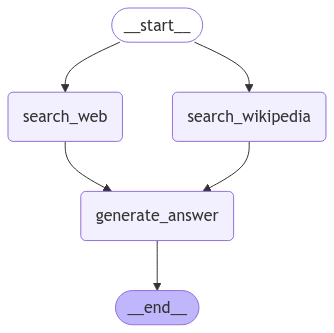

In [32]:
def search_web(state):

    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state):

    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'],
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def generate_answer(state):

    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question,
                                                       context=context)

    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])

    # Append it to state
    return {"answer": answer}

# Add nodes
builder: StateGraph = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [33]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content

"Nvidia's Q2 2024 earnings were exceptionally strong.  Revenue reached $13.51 billion, more than double the previous year's figure.  GAAP net income jumped to $6.2 billion ($2.48 per share), up significantly from $656 million ($0.26 per share) in Q2 2023.  Adjusted EPS was $2.70.  This growth was primarily driven by a 171% year-over-year increase in data center revenue to $10.32 billion, fueled by high demand for AI chips from cloud providers and large tech companies.  The gaming division also saw a 22% year-over-year revenue increase, reaching $2.49 billion."

In [34]:
result

{'question': "How were Nvidia's Q2 2024 earnings",
 'answer': AIMessage(content="Nvidia's Q2 2024 earnings were exceptionally strong.  Revenue reached $13.51 billion, more than double the previous year's figure.  GAAP net income jumped to $6.2 billion ($2.48 per share), up significantly from $656 million ($0.26 per share) in Q2 2023.  Adjusted EPS was $2.70.  This growth was primarily driven by a 171% year-over-year increase in data center revenue to $10.32 billion, fueled by high demand for AI chips from cloud providers and large tech companies.  The gaming division also saw a 22% year-over-year revenue increase, reaching $2.49 billion.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-c2c78b28-7a6f-4b2c-9d93-0ce32166fadd-0', usage_metadata={'input_tokens': 2586, 'output_tokens': 166, 'total_tokens': 2752, 'input_token_details': {'cache_read': 0}}),
 'context': ['<Document hr

In [37]:
result1 = graph.invoke({"question": "tell me history of islam till P.B.U.H "})
result['answer'].content

"Based on the provided text, the history of Islam until the death of the Prophet Muhammad (PBUH) can be summarized as follows:\n\nMuhammad (PBUH), born around 570 AD in Mecca, began receiving revelations from Allah at age 40.  These revelations formed the basis of the Quran and Islam. By 630 AD, he had united most of Arabia under Islam.  Following his death in 632 CE, the issue of succession led to a major schism within Islam.  Sunnis believed the caliph (successor) should be elected from the Quraysh tribe, while Shia believed the caliphate should be hereditary within Muhammad's family, specifically through Ali ibn Abi Talib, his cousin and son-in-law.  This division, along with others like the Kharijites, significantly shaped the early political landscape of Islam.\n\nBefore his death, Muhammad (PBUH) established agreements with various tribal chiefs across the Arabian Peninsula, some alliances, and others acknowledging his prophethood and Islamic practices, including paying alms.  Th

In [38]:
result1

{'question': 'tell me history of islam till P.B.U.H ',
 'answer': AIMessage(content="Based on the provided text, here's a summary of the history of Islam until the death of the Prophet Muhammad (PBUH):\n\nMuhammad, born around 570 AD in Mecca, began receiving revelations from Allah at age 40.  These revelations formed the basis of the Quran and Islam. By 630 AD, he had united most of Arabia under Islam.  The Constitution of Medina, drafted by Muhammad, allowed Jews and Christians to use their own laws and have their own judges.  Following Muhammad's death in 632 CE, various agreements were made with tribal chiefs across the Arabian peninsula, some allying with him, others acknowledging his prophethood and agreeing to follow Islamic practices.  The exact nature and extent of Muhammad's intentions regarding the spread of Islam and his political ambitions remain a subject of scholarly debate.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings